## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [2]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/tilboon/Documents/UCLA/Courses/C247/HW2/HW2_code/cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [6]:
from nndl import Softmax

In [7]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [8]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [9]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:
-ln(0.1) = 2.3. This shows that the probability of choosing the correct class is 10%, which makes sense because the wights are random.


#### Softmax gradient

In [14]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -3.441406 analytic: -3.441406, relative error: 7.371486e-09
numerical: 0.566164 analytic: 0.566164, relative error: 6.158833e-08
numerical: -1.509496 analytic: -1.509496, relative error: 2.205557e-08
numerical: 0.480927 analytic: 0.480927, relative error: 8.133125e-08
numerical: -1.119525 analytic: -1.119526, relative error: 5.768046e-08
numerical: -0.419041 analytic: -0.419041, relative error: 1.806362e-09
numerical: -3.639235 analytic: -3.639235, relative error: 5.895431e-09
numerical: 0.387843 analytic: 0.387843, relative error: 1.610869e-07
numerical: 2.392608 analytic: 2.392608, relative error: 2.146916e-08
numerical: 1.320036 analytic: 1.320036, relative error: 5.961130e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [15]:
import time

In [26]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.33872090924829 / 321.98589570406955 computed in 0.03820514678955078s
Vectorized loss / grad: 2.338720909248289 / 321.98589570406955 computed in 0.002907991409301758s
difference in loss / grad: 8.881784197001252e-16 /2.0394590171326893e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.44515538257882
iteration 100 / 1500: loss 2.102722970807078
iteration 200 / 1500: loss 1.982153270491871
iteration 300 / 1500: loss 1.9716279917796629
iteration 400 / 1500: loss 1.8271622721011465
iteration 500 / 1500: loss 1.8417495237518748
iteration 600 / 1500: loss 1.8891403759151801
iteration 700 / 1500: loss 1.8608596252429663
iteration 800 / 1500: loss 1.8291336459127479
iteration 900 / 1500: loss 1.832292639851959
iteration 1000 / 1500: loss 1.8595635065276859
iteration 1100 / 1500: loss 1.9715495308251019
iteration 1200 / 1500: loss 1.8029841704072975
iteration 1300 / 1500: loss 1.8654046891563791
iteration 1400 / 1500: loss 1.7808285404094022
That took 3.496454954147339s


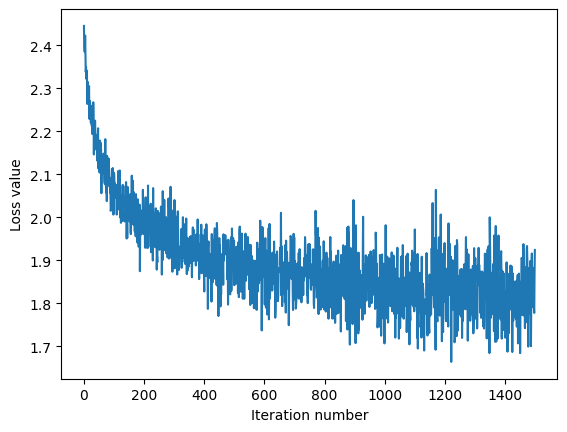

In [69]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [70]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3812857142857143
validation accuracy: 0.379


## Optimize the softmax classifier

In [71]:
np.finfo(float).eps

2.220446049250313e-16

In [80]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

# Array of learning rates
learning_rates = np.logspace(-10, -1, num=30)

best_lr = None
best_val_accuracy = 0
best_softmax = None

for lr in learning_rates:
  softmax = Softmax(dims=[num_classes, num_features])
  softmax.train(X_train, y_train, learning_rate=lr, num_iters=1500, verbose=False)

  # Prediction
  y_pred = softmax.predict(X_val)
  
  accuracy = np.mean(y_val == y_pred)
  val_error = 1 - accuracy
  print(f"Learning Rate: {lr}, Validation Accuracy: {accuracy}")

  # Update
  if accuracy > best_val_accuracy:
    best_val_accuracy = accuracy
    best_lr = lr
    best_val_error = val_error
    #best_softmax = softmax

    # Prediction
    y_pred_test = softmax.predict(X_test)
    test_accuracy = np.mean(y_pred_test == y_test)

    best_test_error_rate = 1 - test_accuracy

print(f"Best Learning Rate: {best_lr}")
print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Best Validation Error: {best_val_error}")
print(f"Test Error Rate for the best classifier: {best_test_error_rate}")

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


Learning Rate: 1e-10, Validation Accuracy: 0.1
Learning Rate: 2.0433597178569396e-10, Validation Accuracy: 0.155
Learning Rate: 4.175318936560409e-10, Validation Accuracy: 0.133
Learning Rate: 8.531678524172814e-10, Validation Accuracy: 0.14
Learning Rate: 1.7433288221999873e-09, Validation Accuracy: 0.19
Learning Rate: 3.5622478902624368e-09, Validation Accuracy: 0.26
Learning Rate: 7.278953843983161e-09, Validation Accuracy: 0.284
Learning Rate: 1.4873521072935118e-08, Validation Accuracy: 0.302
Learning Rate: 3.039195382313195e-08, Validation Accuracy: 0.341
Learning Rate: 6.210169418915617e-08, Validation Accuracy: 0.37
Learning Rate: 1.2689610031679235e-07, Validation Accuracy: 0.397
Learning Rate: 2.592943797404667e-07, Validation Accuracy: 0.408
Learning Rate: 5.298316906283712e-07, Validation Accuracy: 0.416
Learning Rate: 1.0826367338740541e-06, Validation Accuracy: 0.403
Learning Rate: 2.2122162910704504e-06, Validation Accuracy: 0.41
Learning Rate: 4.520353656360241e-06, Val